In [1]:
import os
import torch
import numpy as np
import scipy.misc as m

from torch.utils import data

In [2]:
from ptsemseg.utils import recursive_glob
from ptsemseg.augmentations import Compose, RandomHorizontallyFlip, RandomRotate, Scale

In [3]:
class cityscapesLoader(data.Dataset):
    """cityscapesLoader

    https://www.cityscapes-dataset.com

    Data is derived from CityScapes, and can be downloaded from here:
    https://www.cityscapes-dataset.com/downloads/

    Many Thanks to @fvisin for the loader repo:
    https://github.com/fvisin/dataset_loaders/blob/master/dataset_loaders/images/cityscapes.py
    """

    colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

    label_colours = dict(zip(range(19), colors))

    mean_rgb = {
        "pascal": [103.939, 116.779, 123.68],
        "cityscapes": [0.0, 0.0, 0.0],
    }  # pascal mean for PSPNet and ICNet pre-trained model

    def __init__(
        self,
        root,
        #split="train",
        split="val",
        is_transform=False,
        img_size=(512, 1024),
        augmentations=None,
        img_norm=True,
        version="cityscapes",
        test_mode=False,
    ):
        """__init__

        :param root:
        :param split:
        :param is_transform:
        :param img_size:
        :param augmentations
        """
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.mean = np.array(self.mean_rgb[version])
        self.files = {}

        self.images_base = os.path.join(self.root, "leftImg8bit", self.split)
        self.annotations_base = os.path.join(self.root, "gtFine", self.split)

        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")

        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [
            7,
            8,
            11,
            12,
            13,
            17,
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            31,
            32,
            33,
        ]
        self.class_names = [
            "unlabelled",
            "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "traffic_light",
            "traffic_sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motorcycle",
            "bicycle",
        ]

        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_classes, range(19)))

        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))

        print("Found %d %s images" % (len(self.files[split]), split))

    def __len__(self):
        """__len__"""
        return len(self.files[self.split])

    def __getitem__(self, index):
        """__getitem__

        :param index:
        """
        img_path = self.files[self.split][index].rstrip()
        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
        )

        img = m.imread(img_path)
        img = np.array(img, dtype=np.uint8)

        lbl = m.imread(lbl_path)
        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))

        if self.augmentations is not None:
            img, lbl = self.augmentations(img, lbl)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)

        return img, lbl

    def transform(self, img, lbl):
        """transform

        :param img:
        :param lbl:
        """
        img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), "nearest", mode="F")
        lbl = lbl.astype(int)

        if not np.all(classes == np.unique(lbl)):
            print("WARN: resizing labels yielded fewer classes")

        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
            print("after det", classes, np.unique(lbl))
            raise ValueError("Segmentation map contained invalid class values")

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()

        return img, lbl

    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

    def encode_segmap(self, mask):
        # Put all void classes to zero
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask



Found 500 val images


/home/jdchang/.conda/envs/py36-semseg/lib/python3.6/site-packages/ipykernel_launcher.py:146: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/jdchang/.conda/envs/py36-semseg/lib/python3.6/site-packages/ipykernel_launcher.py:149: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/jdchang/.conda/envs/py36-semseg/lib/python3.6/site-packages/ipykernel_launcher.py:166: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/jdchang/.conda/envs/py36-semseg/lib/python3.6/site-packages/ipykernel_launcher.py:179: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


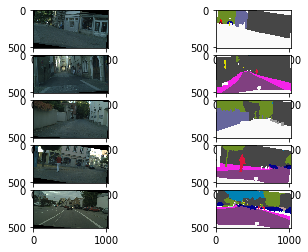

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    augmentations = Compose([Scale(2048), RandomRotate(10), RandomHorizontallyFlip(0.5)])

    local_path = "/datasets/cityscapes/"
#    local_path = "/datasets/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
    
    dst = cityscapesLoader(local_path, is_transform=True, augmentations=augmentations)
    bs = 5
    trainloader = data.DataLoader(dst, batch_size=bs, num_workers=0)
    for i, data_samples in enumerate(trainloader):
        imgs, labels = data_samples
        #import pdb

        #pdb.set_trace()
        imgs = imgs.numpy()[:, ::-1, :, :]
        imgs = np.transpose(imgs, [0, 2, 3, 1])
        f, axarr = plt.subplots(bs, 2)
        for j in range(bs):
            axarr[j][0].imshow(imgs[j])
            axarr[j][1].imshow(dst.decode_segmap(labels.numpy()[j]))
        plt.show()
        a = input()
        if a == "ex":
            break
        else:
            plt.close()
